<a href="https://colab.research.google.com/github/Canihelpme/DeepLearning_finance/blob/main/LSTM_Kospi_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from pathlib import Path

folder = ""
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, RepeatVector, TimeDistributed, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings('ignore')



In [7]:
%matplotlib inline
filename = '/content/drive/MyDrive/Financial_data/Data/train/kospi_train_data.csv'
data = pd.read_csv(filename, sep=",",encoding='UTF-8')
data.head

<bound method NDFrame.head of                 Date       End      Open      High       Low   Amount     Val
0      2020년 02월 21일  2,162.84  2,165.65  2,184.43  2,160.28  635.47M  -1.49%
1      2020년 02월 20일  2,195.50  2,223.55  2,228.18  2,186.72  709.56M  -0.67%
2      2020년 02월 19일  2,210.34  2,222.51  2,226.00  2,191.20  591.16M   0.07%
3      2020년 02월 18일  2,208.88  2,225.98  2,232.93  2,205.21  470.42M  -1.48%
4      2020년 02월 17일  2,242.17  2,243.07  2,250.05  2,230.26  458.25M  -0.06%
...              ...       ...       ...       ...       ...      ...     ...
10383  1981년 05월 07일     119.3     119.3     119.3     119.3    1.48M  -1.16%
10384  1981년 05월 06일     120.7     120.7     120.7     120.7    1.69M   0.08%
10385  1981년 05월 04일     120.6     120.6     120.6     120.6    1.93M  -2.35%
10386  1981년 05월 02일     123.5     123.5     123.5     123.5    2.04M  -0.08%
10387  1981년 05월 01일     123.6     123.6     123.6     123.6    3.33M   0.98%

[10388 rows x 7 columns]>

In [8]:
date_index = data
date_index = date_index.copy()
print(date_index)

                Date       End      Open      High       Low   Amount     Val
0      2020년 02월 21일  2,162.84  2,165.65  2,184.43  2,160.28  635.47M  -1.49%
1      2020년 02월 20일  2,195.50  2,223.55  2,228.18  2,186.72  709.56M  -0.67%
2      2020년 02월 19일  2,210.34  2,222.51  2,226.00  2,191.20  591.16M   0.07%
3      2020년 02월 18일  2,208.88  2,225.98  2,232.93  2,205.21  470.42M  -1.48%
4      2020년 02월 17일  2,242.17  2,243.07  2,250.05  2,230.26  458.25M  -0.06%
...              ...       ...       ...       ...       ...      ...     ...
10383  1981년 05월 07일     119.3     119.3     119.3     119.3    1.48M  -1.16%
10384  1981년 05월 06일     120.7     120.7     120.7     120.7    1.69M   0.08%
10385  1981년 05월 04일     120.6     120.6     120.6     120.6    1.93M  -2.35%
10386  1981년 05월 02일     123.5     123.5     123.5     123.5    2.04M  -0.08%
10387  1981년 05월 01일     123.6     123.6     123.6     123.6    3.33M   0.98%

[10388 rows x 7 columns]


In [9]:
date_index['Date'] = date_index.Date.apply(str).str.replace("년","").str.replace("월","").str.replace("일","")
date_index['Date'] = date_index.Date.str.replace(" ","")

date_index['Amount'] = date_index.Amount.apply(str).str.replace("B", "0000000").str.replace("M","0000").str.replace("K","0").str.replace(".","")
date_index['Amount'] = date_index.Amount.astype(int)

date_index['End'] = date_index.End.apply(str).str.replace(",","").astype(float)
date_index['Open'] = date_index.Open.apply(str).str.replace(",","").astype(float)
date_index['High'] = date_index.High.apply(str).str.replace(",","").astype(float)
date_index['Low'] = date_index.Low.apply(str).str.replace(",","").astype(float)

date_index = date_index.loc[::-1].reset_index(drop=True)
print(date_index)

           Date      End     Open     High      Low     Amount     Val
0      19810501   123.60   123.60   123.60   123.60    3330000   0.98%
1      19810502   123.50   123.50   123.50   123.50    2040000  -0.08%
2      19810504   120.60   120.60   120.60   120.60    1930000  -2.35%
3      19810506   120.70   120.70   120.70   120.70    1690000   0.08%
4      19810507   119.30   119.30   119.30   119.30    1480000  -1.16%
...         ...      ...      ...      ...      ...        ...     ...
10383  20200217  2242.17  2243.07  2250.05  2230.26  458250000  -0.06%
10384  20200218  2208.88  2225.98  2232.93  2205.21  470420000  -1.48%
10385  20200219  2210.34  2222.51  2226.00  2191.20  591160000   0.07%
10386  20200220  2195.50  2223.55  2228.18  2186.72  709560000  -0.67%
10387  20200221  2162.84  2165.65  2184.43  2160.28  635470000  -1.49%

[10388 rows x 7 columns]


In [10]:
date_index['Date'] = pd.to_datetime(date_index['Date'], format='%Y%m%d')
#date_index['year'] = date_index['date'].dt.year
date_index = date_index.set_index('Date')
print(date_index)

                End     Open     High      Low     Amount     Val
Date                                                             
1981-05-01   123.60   123.60   123.60   123.60    3330000   0.98%
1981-05-02   123.50   123.50   123.50   123.50    2040000  -0.08%
1981-05-04   120.60   120.60   120.60   120.60    1930000  -2.35%
1981-05-06   120.70   120.70   120.70   120.70    1690000   0.08%
1981-05-07   119.30   119.30   119.30   119.30    1480000  -1.16%
...             ...      ...      ...      ...        ...     ...
2020-02-17  2242.17  2243.07  2250.05  2230.26  458250000  -0.06%
2020-02-18  2208.88  2225.98  2232.93  2205.21  470420000  -1.48%
2020-02-19  2210.34  2222.51  2226.00  2191.20  591160000   0.07%
2020-02-20  2195.50  2223.55  2228.18  2186.72  709560000  -0.67%
2020-02-21  2162.84  2165.65  2184.43  2160.28  635470000  -1.49%

[10388 rows x 6 columns]


# LSTM을 활용한 주가 예측 모델


LSTM 을 활용한 주가 예측 모델 구축

## 데이터

In [11]:
stock = date_index

In [12]:
stock.head()

,End,Open,High,Low,Amount,Val
Date,,,,,,
1981-05-01,123.6,123.6,123.6,123.6,3330000,0.98%
1981-05-02,123.5,123.5,123.5,123.5,2040000,-0.08%
1981-05-04,120.6,120.6,120.6,120.6,1930000,-2.35%
1981-05-06,120.7,120.7,120.7,120.7,1690000,0.08%
1981-05-07,119.3,119.3,119.3,119.3,1480000,-1.16%


In [13]:
stock.tail()

,End,Open,High,Low,Amount,Val
Date,,,,,,
2020-02-17,2242.17,2243.07,2250.05,2230.26,458250000,-0.06%
2020-02-18,2208.88,2225.98,2232.93,2205.21,470420000,-1.48%
2020-02-19,2210.34,2222.51,2226.00,2191.20,591160000,0.07%
2020-02-20,2195.50,2223.55,2228.18,2186.72,709560000,-0.67%
2020-02-21,2162.84,2165.65,2184.43,2160.28,635470000,-1.49%


In [14]:
stock.index

DatetimeIndex(['1981-05-01', '1981-05-02', '1981-05-04', '1981-05-06',
               '1981-05-07', '1981-05-08', '1981-05-09', '1981-05-12',
               '1981-05-13', '1981-05-14',
               ...
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21'],
              dtype='datetime64[ns]', name='Date', length=10388, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [15]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [16]:
stock.head()

,End,Open,High,Low,Amount,Val,Year,Month,Day
Date,,,,,,,,,
1981-05-01,123.6,123.6,123.6,123.6,3330000,0.98%,1981,5,1
1981-05-02,123.5,123.5,123.5,123.5,2040000,-0.08%,1981,5,2
1981-05-04,120.6,120.6,120.6,120.6,1930000,-2.35%,1981,5,4
1981-05-06,120.7,120.7,120.7,120.7,1690000,0.08%,1981,5,6
1981-05-07,119.3,119.3,119.3,119.3,1480000,-1.16%,1981,5,7


## 시각화

Text(0, 0.5, 'price')

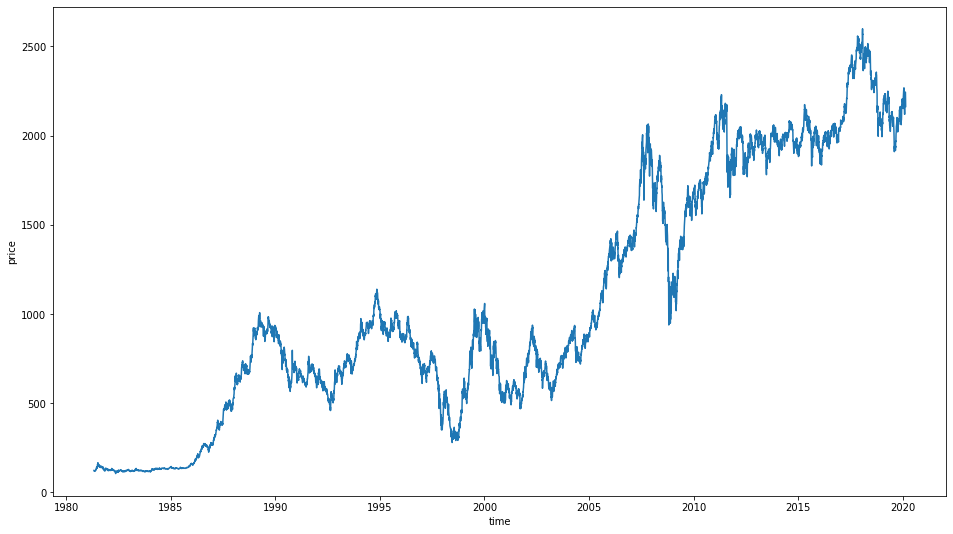

In [17]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['End'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

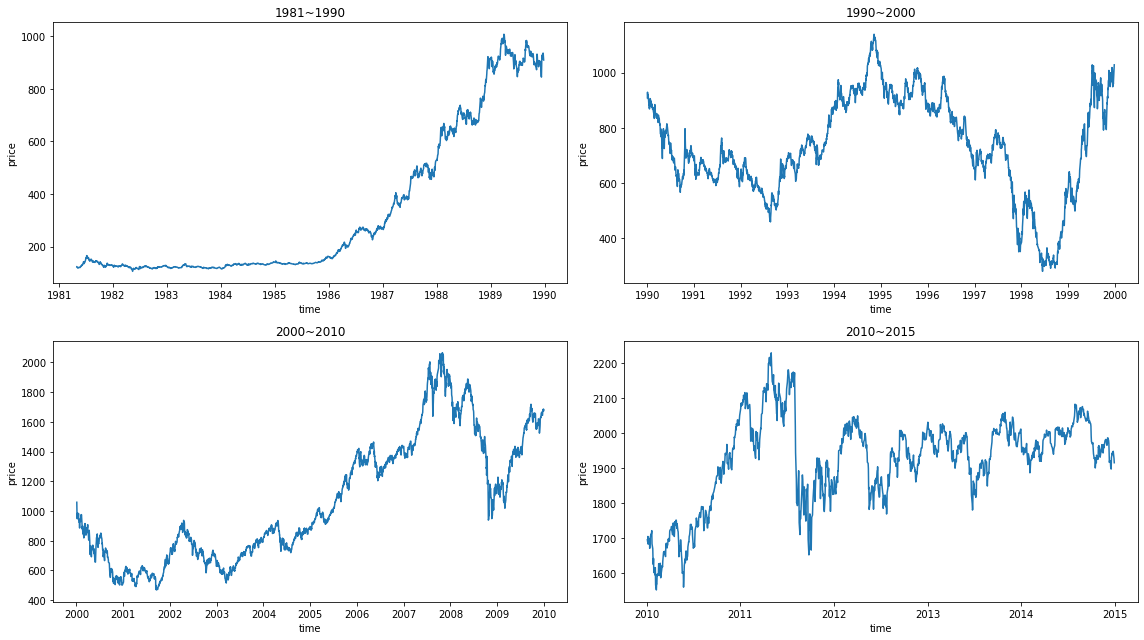

In [19]:
time_steps = [['1981', '1990'],
              ['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['End'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = [ 'Open', 'High', 'Low','End', 'Amount']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.2883355 , 0.28548113, 0.28754902, 0.28543389, 0.01791633],
       [0.28536628, 0.28781265, 0.28758798, 0.28928172, 0.02394197],
       [0.28957954, 0.28795945, 0.28706854, 0.28494213, 0.02206789],
       ...,
       [0.84052883, 0.83545544, 0.82843328, 0.83269275, 0.24833216],
       [0.84097963, 0.83639669, 0.82649404, 0.8262912 , 0.29808366],
       [0.8158821 , 0.81750709, 0.81504904, 0.81220262, 0.26695115]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('End', 1), df['End'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
x_train.shape, y_train.shape

((4799, 4), (4799,))

In [ ]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [ ]:
x_train

,Open,High,Low,Amount
0,0.288336,0.285481,0.287549,0.017916
1,0.285366,0.287813,0.287588,0.023942
2,0.289580,0.287959,0.287069,0.022068
3,0.284824,0.287398,0.284463,0.019358
4,0.292219,0.296374,0.294432,0.023950
...,...,...,...,...
4794,0.755674,0.749643,0.752976,0.188580
4795,0.755609,0.752242,0.753513,0.184630
4796,0.762419,0.758127,0.759625,0.233529
4797,0.759423,0.754733,0.756335,0.228011


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성








In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의

In [ ]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용, test_data는 검증용
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 11s 5ms/step - loss: 0.0015 - mse: 0.0031
Epoch 1: val_loss improved from inf to 0.00028, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 12s 15ms/step - loss: 0.0015 - mse: 0.0031 - val_loss: 2.8275e-04 - val_mse: 5.6550e-04
Epoch 2/50
143/150 [===========================>..] - ETA: 0s - loss: 1.2651e-04 - mse: 2.5301e-04
Epoch 2: val_loss improved from 0.00028 to 0.00016, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 1s 7ms/step - loss: 1.2522e-04 - mse: 2.5044e-04 - val_loss: 1.6216e-04 - val_mse: 3.2433e-04
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 1.1717e-04 - mse: 2.3434e-04
Epoch 3: val_loss did not improve from 0.00016
150/150 [==============================] - 1s 6ms/step - loss: 1.1717e-04 - mse: 2.3434e-04 - val_loss: 1.7388e-04 - val_mse: 3.4776e-04
Epoch 4/50
141/150 [===========================>..] - ETA: 0s - loss: 1.1160e-04 - mse: 2.2320e-04
Epoc

저장한 ModelCheckpoint 를 로드합니다.

In [ ]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.




In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

(1180, 1)

In [ ]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(test_data, pred)

TypeError: ignored

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

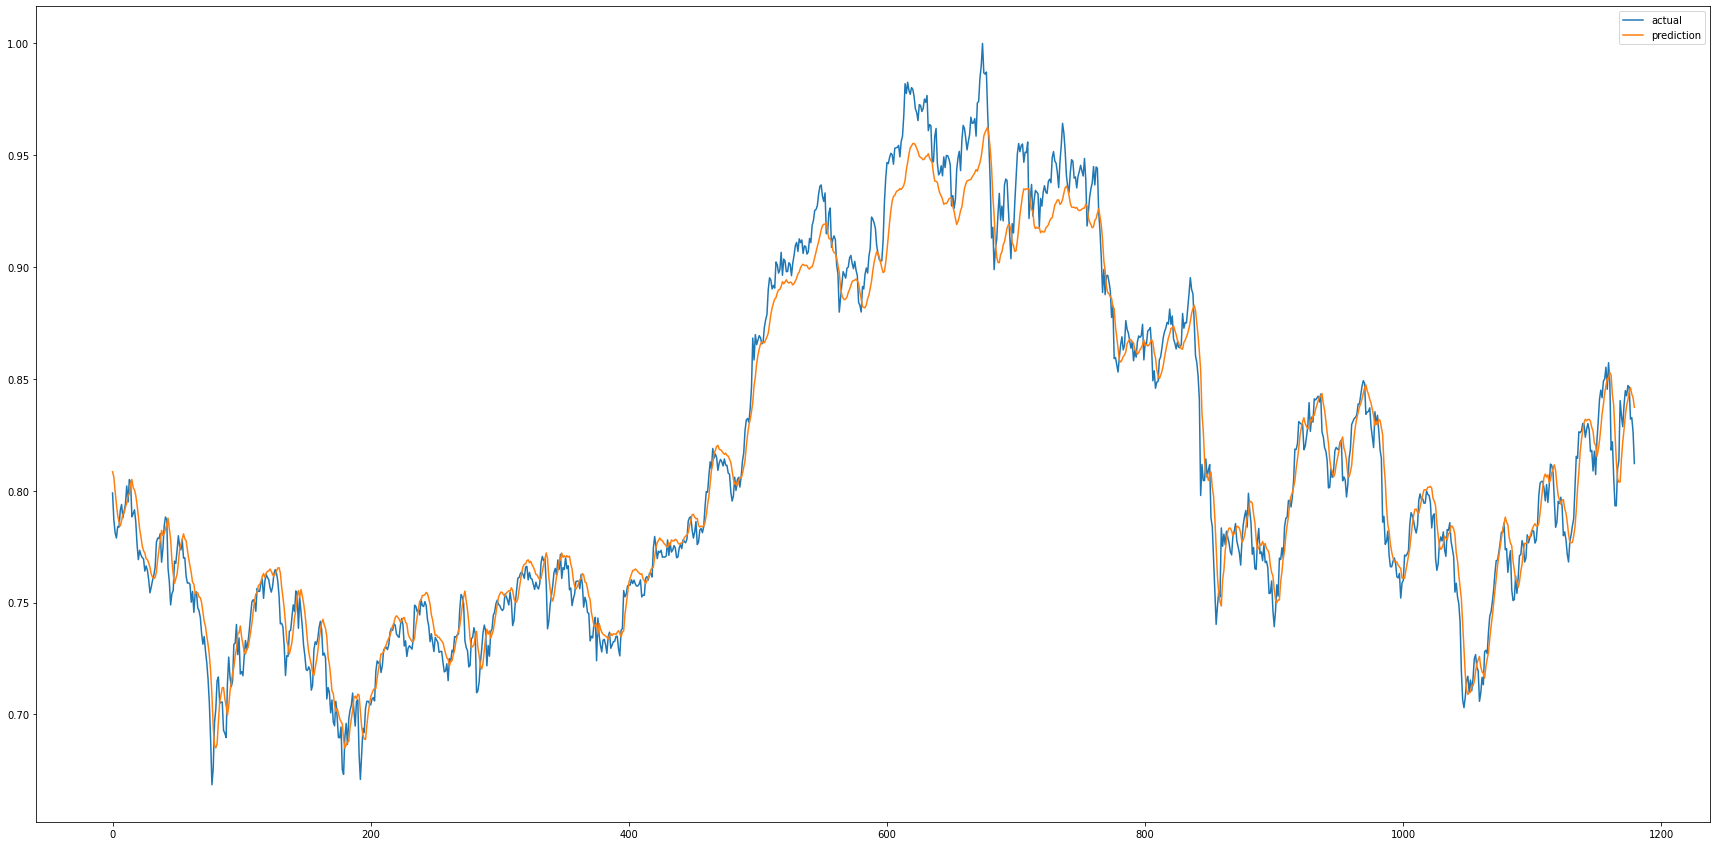

In [ ]:
plt.figure(figsize=(30, 15))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred[:], label='prediction')
plt.legend()
plt.show()

#AutoEncoder

In [ ]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, activation = 'relu', input_shape = (4,)),
    tf.keras.layers.Dense(3, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = None)
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, activation = 'relu', input_shape = (2,)),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = None)
])

autoencoder = tf.keras.models.Sequential([encoder, decoder])

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                    loss = 'mean_squared_error',
                    metrics = ['mse'])

In [ ]:
training = autoencoder.fit(x_train, x_train, batch_size = 30, epochs = 50)

Epoch 1/50
160/160 [==============================] - 1s 2ms/step - loss: 0.0796 - mse: 0.0796
Epoch 2/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0179 - mse: 0.0179
Epoch 3/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0063 - mse: 0.0063
Epoch 4/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029
Epoch 5/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 6/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022
Epoch 7/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022
Epoch 8/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022
Epoch 9/50
160/160 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022
Epoch 10/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022
Epoch 11/50
160/160 [============================

In [ ]:
test_scores = autoencoder.evaluate(x_train, x_train, verbose = 2)
print('Test loss: {}'.format(test_scores[0]))
print('Mean Squared Error: {} %'.format(test_scores[1]*100))

150/150 - 0s - loss: 0.0022 - mse: 0.0022 - 300ms/epoch - 2ms/step
Test loss: 0.002190712606534362
Mean Squared Error: 0.21907126065343618 %


In [ ]:
yhat = autoencoder.predict(x_train, verbose=0)
print(np.round(yhat,20))

[[0.28655562 0.2841155  0.28449    0.14329238]
 [0.28780395 0.28535888 0.28573176 0.14333975]
 [0.28880057 0.2863515  0.28672314 0.14337759]
 ...
 [0.7628859  0.7585507  0.75832003 0.16137192]
 [0.7595177  0.75519586 0.7549694  0.16124406]
 [0.76057315 0.75624716 0.7560194  0.16128413]]


#LSTM Encoder

In [ ]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [ ]:
timeseries = x_train.to_numpy()
timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]

timeseries

array([[0.2883355 , 0.28548113, 0.28754902, 0.01791633],
       [0.28536628, 0.28781265, 0.28758798, 0.02394197],
       [0.28957954, 0.28795945, 0.28706854, 0.02206789],
       ...,
       [0.76241873, 0.75812684, 0.75962479, 0.23352857],
       [0.75942349, 0.75473319, 0.756335  , 0.22801136],
       [0.76007369, 0.75534198, 0.75788467, 0.275519  ]])

In [ ]:
timesteps = 5
X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)

n_features = 4
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)
X

array([[[0.28957954, 0.28795945, 0.28706854, 0.02206789],
        [0.28482445, 0.28739816, 0.28446268, 0.01935761],
        [0.29221933, 0.29637449, 0.2944316 , 0.02395038],
        [0.29528825, 0.29405593, 0.29535361, 0.01847939],
        [0.29524057, 0.29280382, 0.29734912, 0.01242433]],

       [[0.28482445, 0.28739816, 0.28446268, 0.01935761],
        [0.29221933, 0.29637449, 0.2944316 , 0.02395038],
        [0.29528825, 0.29405593, 0.29535361, 0.01847939],
        [0.29524057, 0.29280382, 0.29734912, 0.01242433],
        [0.29712614, 0.300541  , 0.29933165, 0.02448823]],

       [[0.29221933, 0.29637449, 0.2944316 , 0.02395038],
        [0.29528825, 0.29405593, 0.29535361, 0.01847939],
        [0.29524057, 0.29280382, 0.29734912, 0.01242433],
        [0.29712614, 0.300541  , 0.29933165, 0.02448823],
        [0.30408322, 0.30233281, 0.30329671, 0.02890872]],

       ...,

       [[0.76278717, 0.75815707, 0.7621787 , 0.17784387],
        [0.75586909, 0.75372287, 0.7541144 , 0.143744

In [ ]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 5, 128)            68096     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 5, 64)            0         
 or)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 5, 64)             33024     
                                                                 
 lstm_16 (LSTM)              (None, 5, 128)            98816     
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 4)             516       
 tributed)                                            

In [ ]:
# fit model
model.fit(X, X, epochs=300, batch_size=4793, verbose=2)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,20))
print('---Actual---')
print(np.round(X, 20))

Epoch 1/300
1/1 - 0s - loss: 2.5864e-04 - 52ms/epoch - 52ms/step
Epoch 2/300
1/1 - 0s - loss: 2.5695e-04 - 46ms/epoch - 46ms/step
Epoch 3/300
1/1 - 0s - loss: 2.5706e-04 - 46ms/epoch - 46ms/step
Epoch 4/300
1/1 - 0s - loss: 2.5826e-04 - 46ms/epoch - 46ms/step
Epoch 5/300
1/1 - 0s - loss: 2.5934e-04 - 47ms/epoch - 47ms/step
Epoch 6/300
1/1 - 0s - loss: 2.5940e-04 - 40ms/epoch - 40ms/step
Epoch 7/300
1/1 - 0s - loss: 2.5828e-04 - 41ms/epoch - 41ms/step
Epoch 8/300
1/1 - 0s - loss: 2.5659e-04 - 35ms/epoch - 35ms/step
Epoch 9/300
1/1 - 0s - loss: 2.5525e-04 - 35ms/epoch - 35ms/step
Epoch 10/300
1/1 - 0s - loss: 2.5477e-04 - 39ms/epoch - 39ms/step
Epoch 11/300
1/1 - 0s - loss: 2.5507e-04 - 40ms/epoch - 40ms/step
Epoch 12/300
1/1 - 0s - loss: 2.5565e-04 - 40ms/epoch - 40ms/step
Epoch 13/300
1/1 - 0s - loss: 2.5600e-04 - 36ms/epoch - 36ms/step
Epoch 14/300
1/1 - 0s - loss: 2.5582e-04 - 34ms/epoch - 34ms/step
Epoch 15/300
1/1 - 0s - loss: 2.5519e-04 - 34ms/epoch - 34ms/step
Epoch 16/300
1/1 - 

#CNN

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')
